<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Alzheimer%E2%80%99s_Dementia_Speech_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub

In [2]:
import os
import tarfile
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from pydub import AudioSegment
from pydub.silence import split_on_silence
import soundfile as sf
from sklearn.preprocessing import StandardScaler
import uuid
from pathlib import Path

In [3]:
# Step 1: Load Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to the .tgz files
data_path = '/content/drive/MyDrive/Voice/ADRESS021/'
train_prog_tgz = os.path.join(data_path, 'ADRESS021-progression-train.tgz')
test_prog_tgz = os.path.join(data_path, 'ADRESS021-progression-test.tgz')
train_diag_tgz = os.path.join(data_path, 'ADRESS021-diagnosis-train.tgz')

# Extract .tgz files
extracted_path = '/content/adress021_data/'
os.makedirs(extracted_path, exist_ok=True)

Mounted at /content/drive


In [4]:
import tarfile
import glob
import os

# Define file paths
train_prog_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz'
test_prog_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz'
train_diag_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz'
extracted_path = '/content/extracted_audio'  # Directory to extract files to

# Ensure extracted_path exists
os.makedirs(extracted_path, exist_ok=True)

# Function to extract .tgz files
def extract_tgz(tgz_path, extract_to):
    try:
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Successfully extracted {tgz_path} to {extract_to}")
    except FileNotFoundError:
        print(f"Error: File {tgz_path} not found.")
    except Exception as e:
        print(f"Error extracting {tgz_path}: {str(e)}")

# Extract each .tgz file
for tgz in [train_prog_tgz, test_prog_tgz, train_diag_tgz]:
    if os.path.exists(tgz):
        extract_tgz(tgz, extracted_path)
    else:
        print(f"Skipping {tgz}: File does not exist.")

# Find all WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz to /content/extracted_audio
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz to /content/extracted_audio
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/extracted_audio
Found 271 audio files.


In [5]:
# Load metadata (assuming there's a CSV or text file with labels)
# Modify this based on actual metadata structure
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if metadata_path:
    metadata = pd.read_csv(metadata_path[0])
    print("Metadata loaded:")
    print(metadata.head())
else:
    metadata = pd.DataFrame({'file': audio_files, 'label': 'unknown'})
    print("No metadata CSV found. Using file paths only.")

Metadata loaded:
   Unnamed: 0 speaker  begin    end
0           1     INV  30000  32108
1           2     PAR  32108  33057
2           3     INV  33057  35367
3           4     PAR  35367  38537
4           5     PAR  38537  40233


In [6]:
import os
import glob
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load metadata
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if not metadata_path:
    raise FileNotFoundError("No metadata CSV found in extracted path.")

# Inspect available CSV files
print("Found CSV files:", metadata_path)

# Load and inspect the first CSV to check columns
metadata = pd.read_csv(metadata_path[0])
print("Metadata columns:", metadata.columns.tolist())
print("Metadata preview:")
print(metadata.head())

# Check for required columns
required_columns = ['adressfname', 'dx', 'mmse']
if not all(col in metadata.columns for col in required_columns):
    print(f"Error: Required columns {required_columns} not found in {metadata_path[0]}")
    # Try to find the correct CSV
    for csv_path in metadata_path:
        temp_metadata = pd.read_csv(csv_path)
        if all(col in temp_metadata.columns for col in required_columns):
            metadata = temp_metadata
            print(f"Found correct metadata in {csv_path}")
            break
    else:
        raise ValueError("No CSV file contains required columns: 'adressfname', 'dx', 'mmse'")

# Ensure 'dx' is string
metadata['dx'] = metadata['dx'].astype(str)

# Step 2: Find WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

# Step 3: Match audio files with metadata
audio_metadata = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row['dx'].iloc[0],
            'mmse': matching_row['mmse'].iloc[0]
        })
audio_metadata = pd.DataFrame(audio_metadata)
print(f"Matched {len(audio_metadata)} audio files with metadata.")

# Step 4: Limit to a subset for testing
subset_size = 10  # Adjust as needed
audio_metadata = audio_metadata[:subset_size]
print(f"Processing {len(audio_metadata)} files for testing.")

Found CSV files: ['/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp179.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp101.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp266.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp300.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp313.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp051.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp003.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp127.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp209.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp055.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/no_decline/adrs

In [7]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Metadata is already loaded from your output
# Assuming metadata is now correctly loaded from adresso-train-mmse-scores.csv
# audio_metadata contains 10 files for testing
print("Audio metadata preview:")
print(audio_metadata.head())

# Preprocessing function for a single audio file
def process_audio(audio_file, sr=16000, skip_noise_removal=True):
    try:
        # Load audio
        y, orig_sr = librosa.load(audio_file, sr=sr, mono=True)

        # Skip noise removal to save time on CPU
        y_processed = y if skip_noise_removal else librosa.decompose.nn_filter(y, aggregate=np.median, metric='cosine')

        # Trim silence
        y_trimmed, _ = librosa.effects.trim(y_processed, top_db=20)

        # Feature Extraction
        # Acoustic: MFCCs (reduced to 13 for CPU efficiency)
        mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)

        # Prosodic: Pitch, Energy
        pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
        pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
        energy = np.mean(librosa.feature.rms(y=y_trimmed))

        # Linguistic: Placeholder (requires ASR)
        linguistic_features = np.array([0, 0])

        # Combine features
        features = np.concatenate([mfccs_mean, [pitch_mean, energy], linguistic_features])

        return y_trimmed, features
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None, None

# Process all files
processed_features = []
processed_audio_paths = []
labels = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Processing audio files"):
    y_trimmed, features = process_audio(row['file'])
    if y_trimmed is None or features is None:
        continue

    # Save processed audio
    output_path = os.path.join(output_dir, os.path.basename(row['file']))
    sf.write(output_path, y_trimmed, 16000)

    processed_features.append(features)
    processed_audio_paths.append(output_path)
    labels.append(row['label'])

    print(f"Processed: {os.path.basename(row['file'])} (Label: {row['label']})")

# Convert to numpy arrays
processed_features = np.array(processed_features)
labels = np.array(labels)
print(f"Extracted features shape: {processed_features.shape}")
print(f"Labels shape: {labels.shape}")

# Feature Normalization
if processed_features.size > 0:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(processed_features)

    # Data Augmentation (simple noise addition)
    augmented_features = normalized_features + np.random.normal(0, 0.01, normalized_features.shape)

    # Export Features
    np.save(os.path.join(output_dir, 'normalized_features.npy'), normalized_features)
    np.save(os.path.join(output_dir, 'augmented_features.npy'), augmented_features)
    np.save(os.path.join(output_dir, 'labels.npy'), labels)

    # Save processed audio file list and metadata
    audio_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
    with open(os.path.join(output_dir, 'processed_audio_files.txt'), 'w') as f:
        for path in processed_audio_paths:
            f.write(f"{path}\n")

    print(f"Features and metadata saved to {output_dir}")
else:
    print("No features extracted. Check audio files and metadata matching.")

Audio metadata preview:
                                                file label  mmse
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    23
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    19
3  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    10
4  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    20


Processing audio files:  10%|█         | 1/10 [00:21<03:09, 21.10s/it]

Processed: adrso228.wav (Label: ad)


Processing audio files:  20%|██        | 2/10 [00:21<01:12,  9.09s/it]

Processed: adrso055.wav (Label: ad)


Processing audio files:  30%|███       | 3/10 [00:22<00:38,  5.46s/it]

Processed: adrso200.wav (Label: ad)


Processing audio files:  40%|████      | 4/10 [00:23<00:21,  3.58s/it]

Processed: adrso229.wav (Label: ad)


Processing audio files:  50%|█████     | 5/10 [00:24<00:13,  2.60s/it]

Processed: adrso220.wav (Label: ad)


Processing audio files:  60%|██████    | 6/10 [00:25<00:07,  1.97s/it]

Processed: adrso043.wav (Label: ad)


Processing audio files:  70%|███████   | 7/10 [00:25<00:04,  1.42s/it]

Processed: adrso211.wav (Label: ad)


Processing audio files:  80%|████████  | 8/10 [00:25<00:02,  1.11s/it]

Processed: adrso116.wav (Label: ad)


Processing audio files:  90%|█████████ | 9/10 [00:26<00:00,  1.00it/s]

Processed: adrso049.wav (Label: ad)


Processing audio files: 100%|██████████| 10/10 [00:26<00:00,  2.70s/it]

Processed: adrso125.wav (Label: ad)
Extracted features shape: (10, 17)
Labels shape: (10,)
Features and metadata saved to /content/processed_features/


In [8]:
print(audio_metadata[['file', 'label', 'mmse']])

                                                file label  mmse
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    23
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    19
3  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    10
4  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    20
5  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    22
6  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    15
7  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    12
8  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    18
9  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17


In [9]:
!cp -r /content/processed_features /content/drive/MyDrive/Voice/processed_features

Features DataFrame preview:
     MFCC_0    MFCC_1    MFCC_2    MFCC_3    MFCC_4    MFCC_5    MFCC_6  \
0  1.269451  1.839943  1.131352  1.467590  1.859913  1.130438 -0.104594   
1  0.060272 -0.628557 -1.442071 -0.929895 -0.825610 -0.815042 -0.375308   
2  1.474172  0.779267  0.910318  0.183967  1.014591  1.206119  0.980518   
3  0.605732  0.596215  0.096881 -1.260637 -0.017705  0.317644 -0.591044   
4 -0.817753 -0.608329 -0.950939 -0.327951  1.018102  1.704658  1.986983   

     MFCC_7    MFCC_8    MFCC_9   MFCC_10   MFCC_11   MFCC_12     Pitch  \
0 -0.286502  0.162309 -0.119673  0.498058  0.261675 -2.189979 -0.835995   
1 -0.219248 -0.200630 -0.375303 -0.190951 -0.609662  1.041908 -0.109962   
2  2.624364  0.364604  1.470452  0.082664  1.641115 -0.310345  1.134809   
3 -1.207786 -0.050079  0.785449 -0.379700 -1.113957  0.131158  0.174781   
4  0.301302  1.550317  1.700802  2.166135 -0.087395  0.859100  0.853410   

     Energy  Linguistic_1  Linguistic_2 label  mmse  
0 -0.051579     

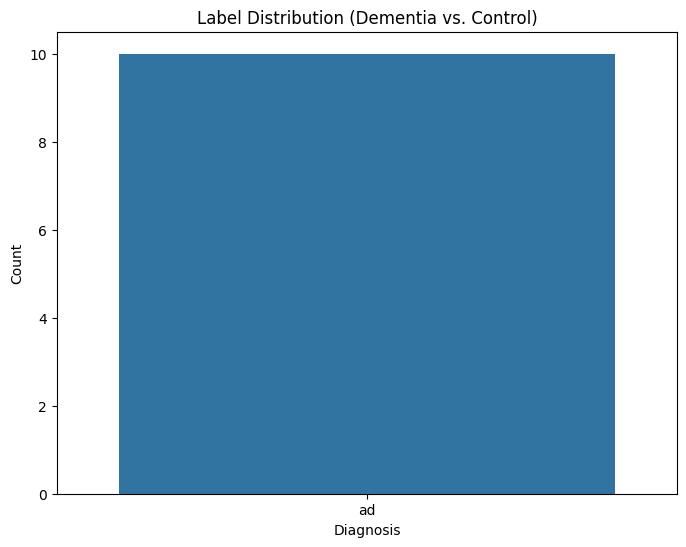

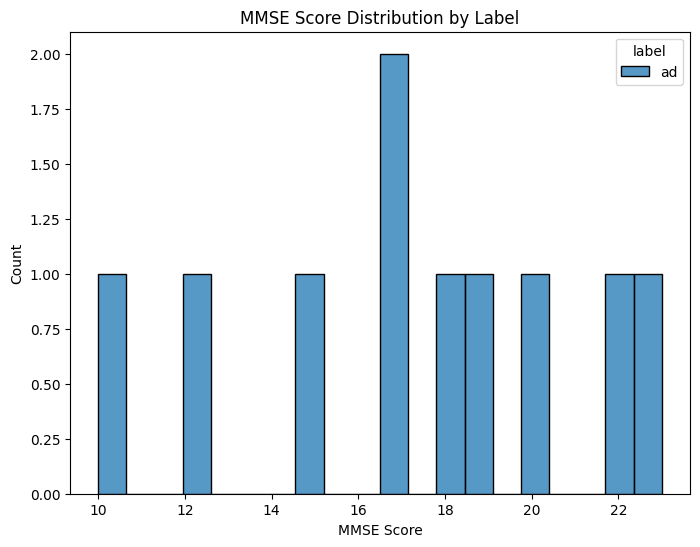

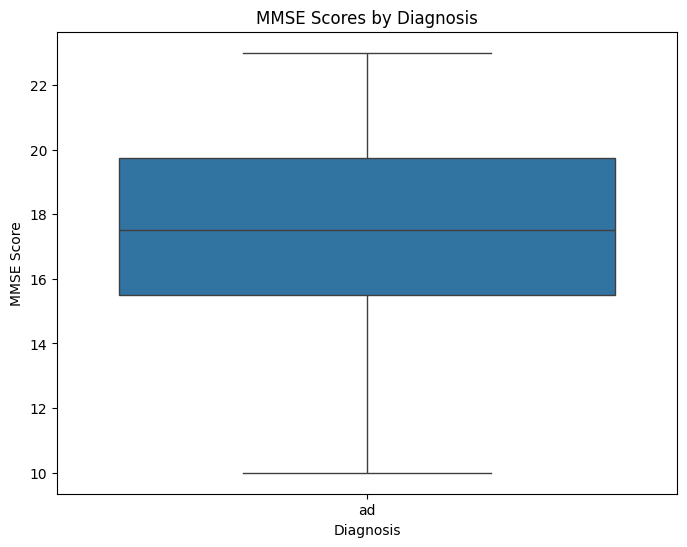

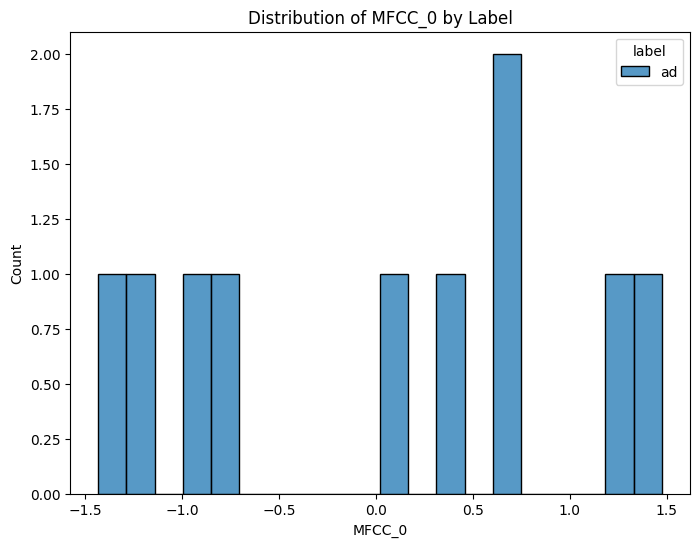

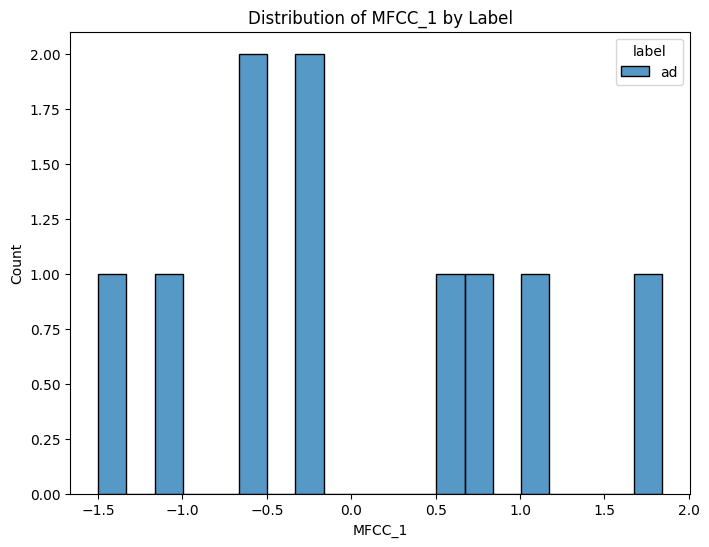

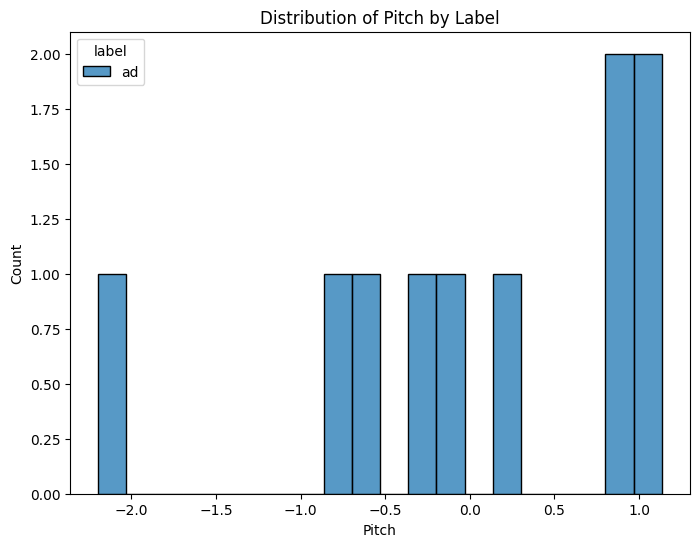

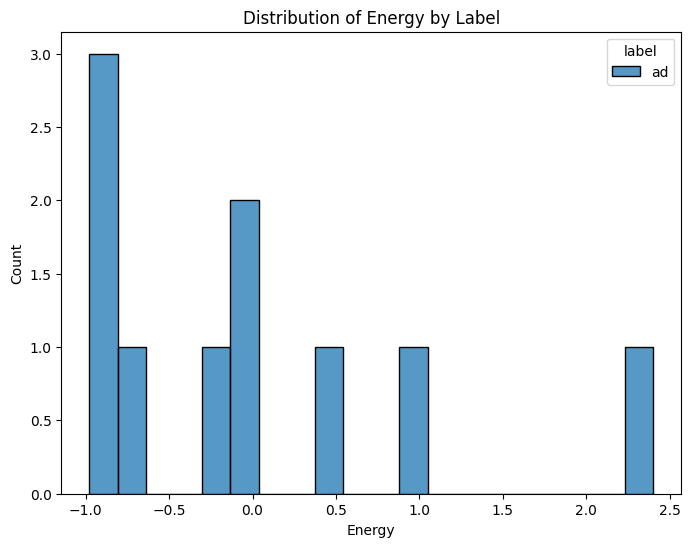

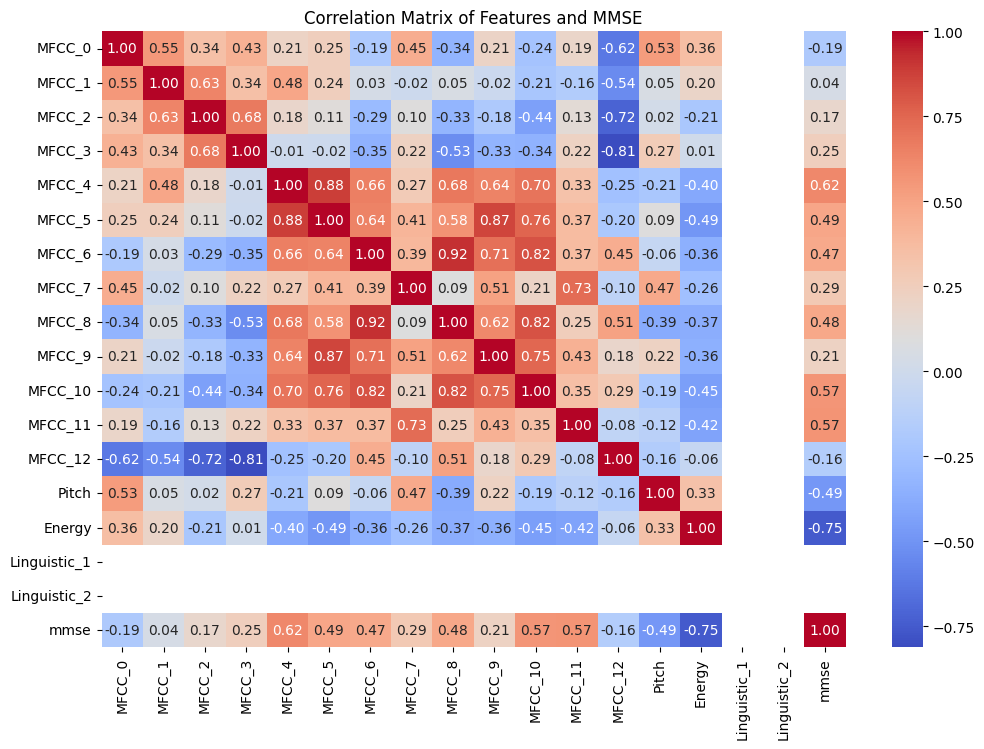

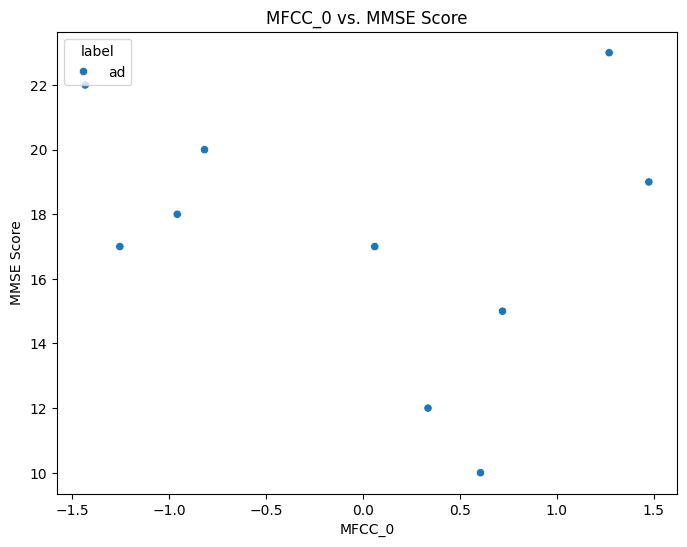

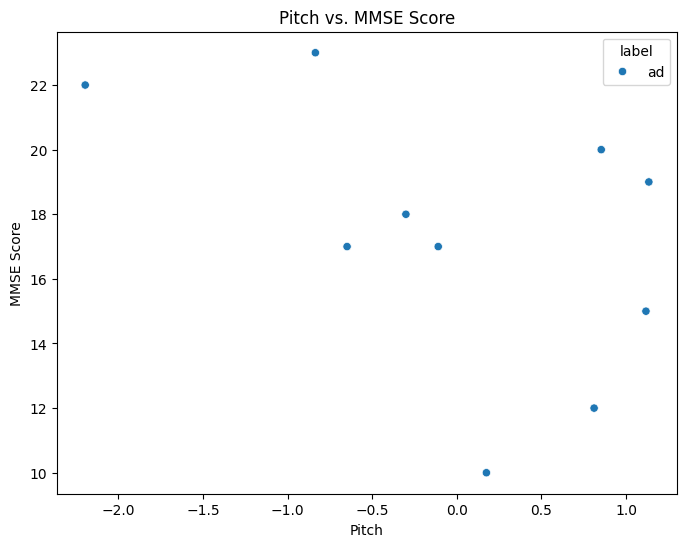

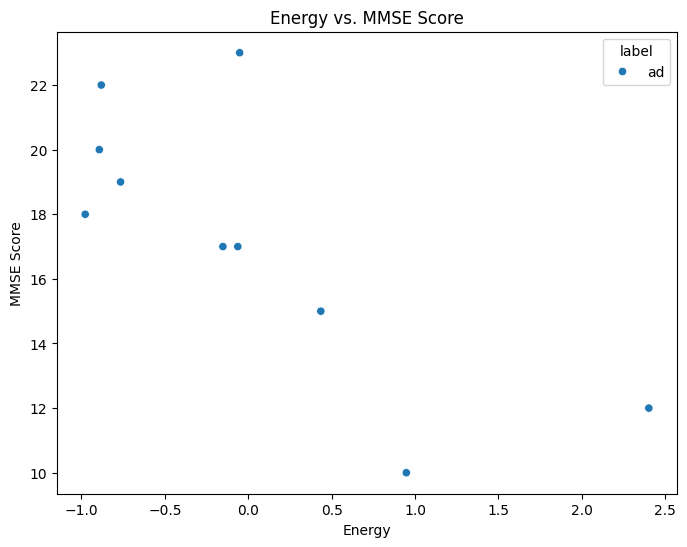

Calculating audio durations: 100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


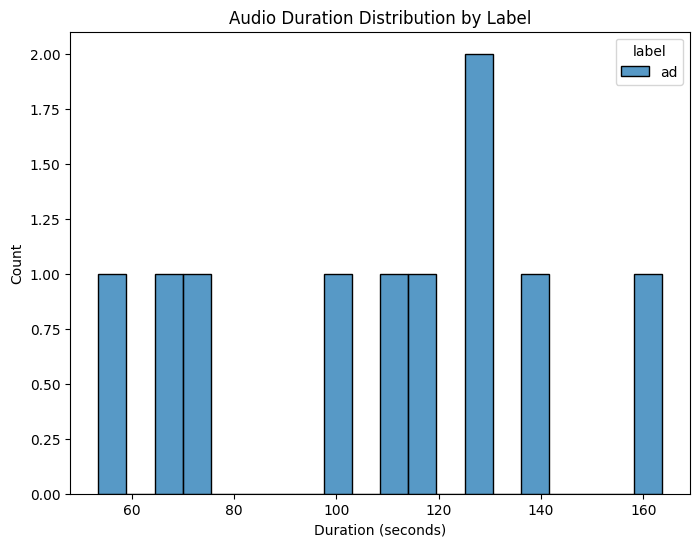

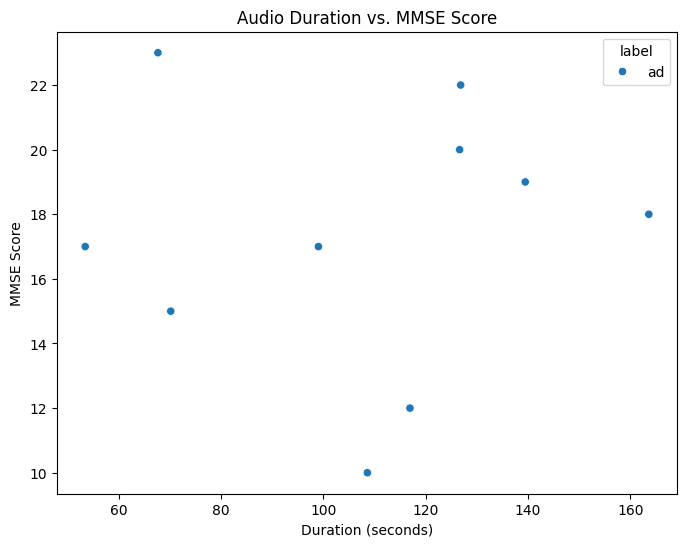

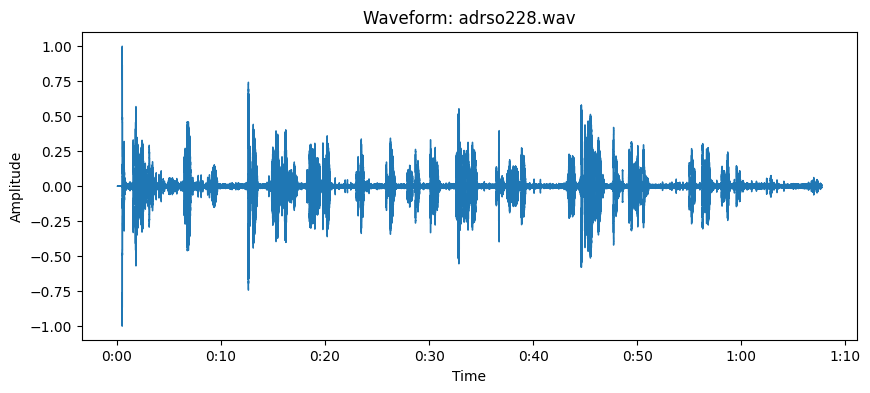

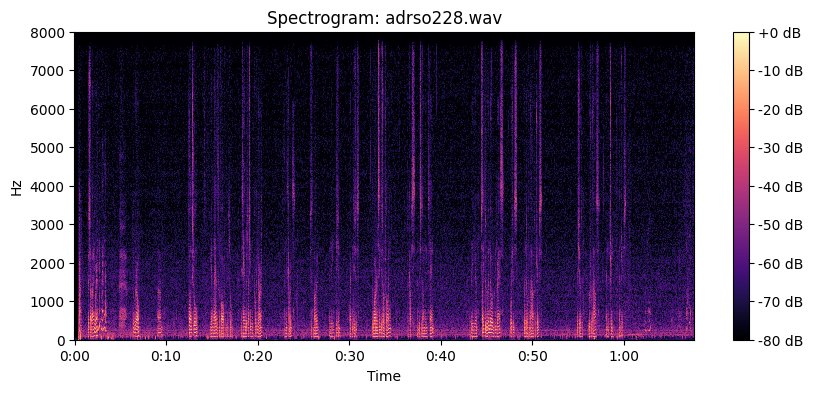

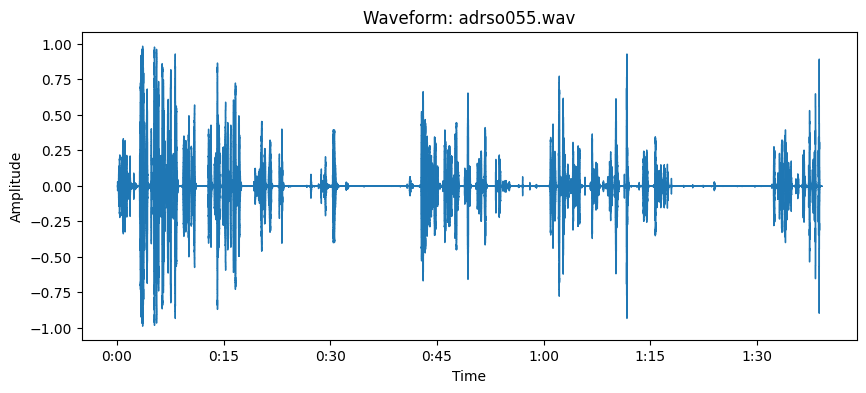

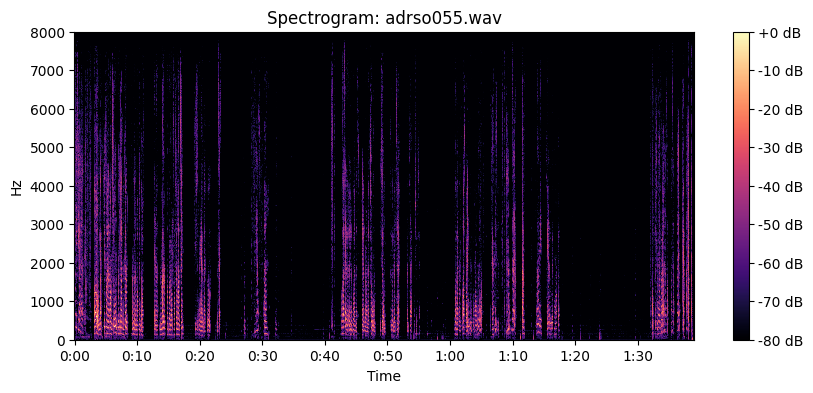

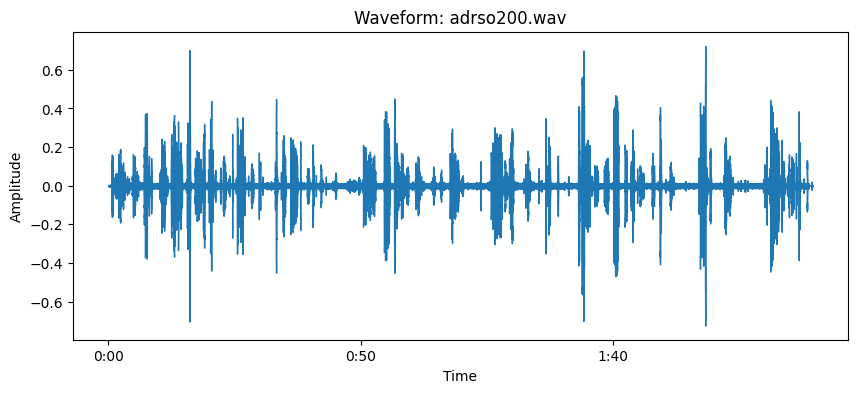

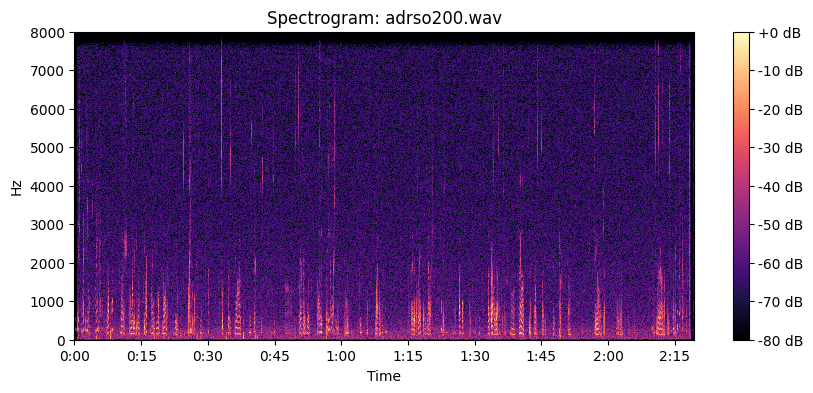

All EDA plots saved to /content/processed_features/eda_plots


In [10]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
eda_dir = os.path.join(output_dir, 'eda_plots')
os.makedirs(eda_dir, exist_ok=True)

# Load processed metadata and features
audio_metadata = pd.read_csv(os.path.join(output_dir, 'processed_metadata.csv'))
normalized_features = np.load(os.path.join(output_dir, 'normalized_features.npy'))
labels = np.load(os.path.join(output_dir, 'labels.npy'))

# Convert features to DataFrame for easier analysis
feature_columns = [f'MFCC_{i}' for i in range(13)] + ['Pitch', 'Energy', 'Linguistic_1', 'Linguistic_2']
features_df = pd.DataFrame(normalized_features, columns=feature_columns)
features_df['label'] = labels
features_df['mmse'] = audio_metadata['mmse']

print("Features DataFrame preview:")
print(features_df.head())

# Step 1: Metadata Analysis
# 1.1 Label Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=audio_metadata, x='label')
plt.title('Label Distribution (Dementia vs. Control)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig(os.path.join(eda_dir, 'label_distribution.png'))
plt.show()

# 1.2 MMSE Score Distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=audio_metadata, x='mmse', hue='label', multiple='stack', bins=20)
plt.title('MMSE Score Distribution by Label')
plt.xlabel('MMSE Score')
plt.ylabel('Count')
plt.savefig(os.path.join(eda_dir, 'mmse_distribution.png'))
plt.show()

# 1.3 MMSE vs. Label (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(data=audio_metadata, x='label', y='mmse')
plt.title('MMSE Scores by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('MMSE Score')
plt.savefig(os.path.join(eda_dir, 'mmse_boxplot.png'))
plt.show()

# Step 2: Feature Analysis
# 2.1 Feature Distributions by Label
for feature in ['MFCC_0', 'MFCC_1', 'Pitch', 'Energy']:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=features_df, x=feature, hue='label', multiple='stack', bins=20)
    plt.title(f'Distribution of {feature} by Label')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.savefig(os.path.join(eda_dir, f'{feature}_distribution.png'))
    plt.show()

# 2.2 Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = features_df[feature_columns + ['mmse']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features and MMSE')
plt.savefig(os.path.join(eda_dir, 'correlation_matrix.png'))
plt.show()

# 2.3 Feature vs. MMSE (Scatter Plots)
for feature in ['MFCC_0', 'Pitch', 'Energy']:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=features_df, x=feature, y='mmse', hue='label', style='label')
    plt.title(f'{feature} vs. MMSE Score')
    plt.xlabel(feature)
    plt.ylabel('MMSE Score')
    plt.savefig(os.path.join(eda_dir, f'{feature}_vs_mmse.png'))
    plt.show()

# Step 3: Audio Characteristics
# 3.1 Audio Duration Analysis
audio_durations = []
for file in tqdm(audio_metadata['file'], desc="Calculating audio durations"):
    try:
        y, sr = librosa.load(file, sr=16000)
        duration = librosa.get_duration(y=y, sr=sr)
        audio_durations.append(duration)
    except Exception as e:
        print(f"Error processing {file}: {e}")
        audio_durations.append(0)

audio_metadata['duration'] = audio_durations

# Plot duration distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=audio_metadata, x='duration', hue='label', multiple='stack', bins=20)
plt.title('Audio Duration Distribution by Label')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.savefig(os.path.join(eda_dir, 'duration_distribution.png'))
plt.show()

# Duration vs. MMSE
plt.figure(figsize=(8, 6))
sns.scatterplot(data=audio_metadata, x='duration', y='mmse', hue='label', style='label')
plt.title('Audio Duration vs. MMSE Score')
plt.xlabel('Duration (seconds)')
plt.ylabel('MMSE Score')
plt.savefig(os.path.join(eda_dir, 'duration_vs_mmse.png'))
plt.show()

# 3.2 Waveform and Spectrogram for Sample Files
sample_files = audio_metadata['file'].head(3).tolist()
for file in sample_files:
    y, sr = librosa.load(file, sr=16000)

    # Waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform: {os.path.basename(file)}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.savefig(os.path.join(eda_dir, f'waveform_{os.path.basename(file)}.png'))
    plt.show()

    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram: {os.path.basename(file)}')
    plt.savefig(os.path.join(eda_dir, f'spectrogram_{os.path.basename(file)}.png'))
    plt.show()

print(f"All EDA plots saved to {eda_dir}")

In [11]:
from scipy.stats import ttest_ind
for feature in feature_columns:
    dementia = features_df[features_df['label'] == ' reverie dementia'][feature]
    control = features_df[features_df['label'] == 'control'][feature]
    stat, p = ttest_ind(dementia, control)
    print(f"{feature}: p-value = {p:.4f}")

MFCC_0: p-value = nan
MFCC_1: p-value = nan
MFCC_2: p-value = nan
MFCC_3: p-value = nan
MFCC_4: p-value = nan
MFCC_5: p-value = nan
MFCC_6: p-value = nan
MFCC_7: p-value = nan
MFCC_8: p-value = nan
MFCC_9: p-value = nan
MFCC_10: p-value = nan
MFCC_11: p-value = nan
MFCC_12: p-value = nan
Pitch: p-value = nan
Energy: p-value = nan
Linguistic_1: p-value = nan
Linguistic_2: p-value = nan


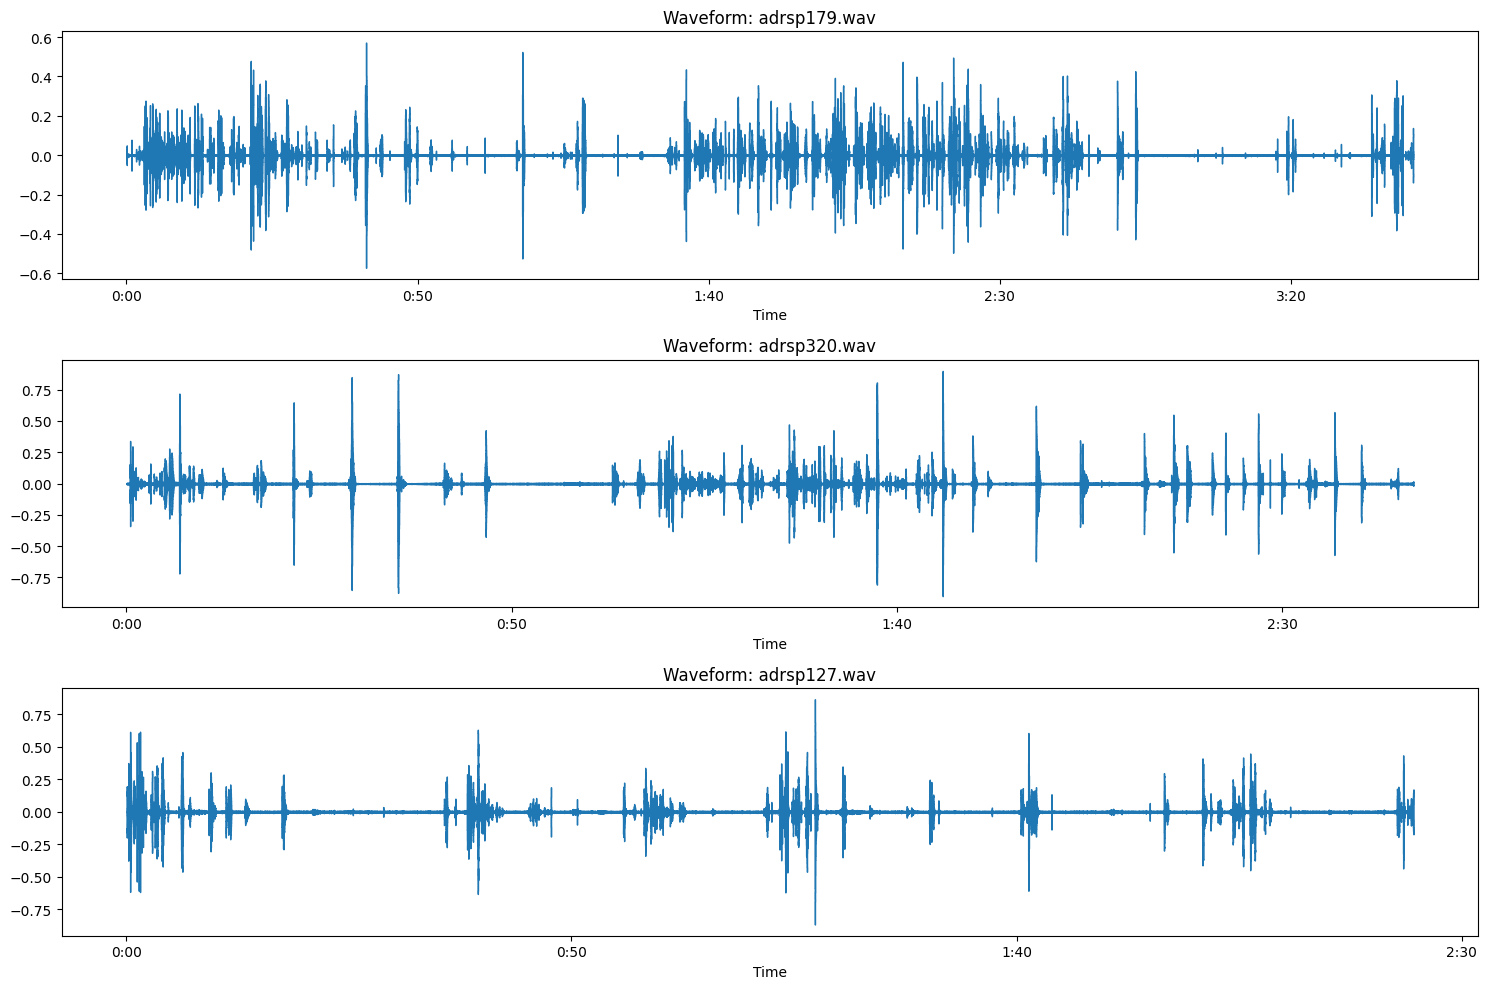


Sample Metadata:
   Unnamed: 0 speaker  begin    end
0           1     INV  30000  32108
1           2     PAR  32108  33057
2           3     INV  33057  35367
3           4     PAR  35367  38537
4           5     PAR  38537  40233


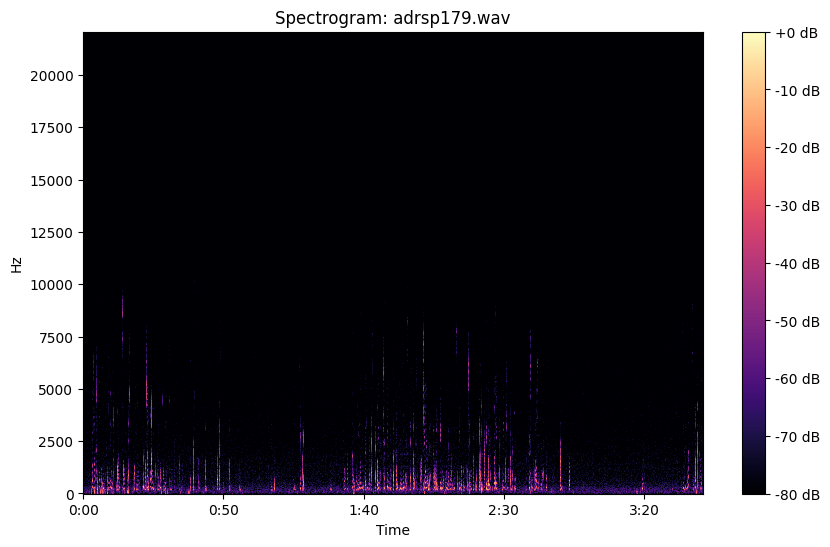

No label column found in metadata.


In [ ]:
# Step 2: Visualize and Explore Dataset
# Select a few sample audio files
sample_files = audio_files[:3]

# Visualize waveforms
plt.figure(figsize=(15, 10))
for i, audio_file in enumerate(sample_files):
    y, sr = librosa.load(audio_file, sr=None)
    plt.subplot(len(sample_files), 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(audio_file)}")
plt.tight_layout()
plt.savefig('/content/waveforms.png')
plt.show()

# Show sample metadata
print("\nSample Metadata:")
print(metadata.head())

# Plot spectrogram for one sample
y, sr = librosa.load(sample_files[0], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram: {os.path.basename(sample_files[0])}")
plt.savefig('/content/spectrogram.png')
plt.show()

# Show label distribution (assuming metadata has a 'label' column)
if 'label' in metadata.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=metadata, x='label')
    plt.title('Label Distribution')
    plt.savefig('/content/label_distribution.png')
    plt.show()
else:
    print("No label column found in metadata.")

In [ ]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
extracted_path = '/content/extracted_audio/'  # Corrected from /content/adress021_data/
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Load metadata (assuming CSV from Step 1/2)
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if metadata_path:
    metadata = pd.read_csv(metadata_path[0])
    metadata['dx'] = metadata['dx'].astype(str)  # Ensure dx is string
else:
    raise FileNotFoundError("Metadata CSV not found in extracted path.")

# Find WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

# Match audio files with metadata
# Assume adressfname (e.g., adrso024) corresponds to file name (e.g., adrso024.wav)
audio_metadata = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row['dx'].iloc[0],
            'mmse': matching_row['mmse'].iloc[0]
        })
audio_metadata = pd.DataFrame(audio_metadata)
print(f"Matched {len(audio_metadata)} audio files with metadata.")

# Limit to a subset for testing
subset_size = 10  # Adjust as needed
audio_metadata = audio_metadata[:subset_size]
print(f"Processing {len(audio_metadata)} files for testing.")

# Preprocessing function for a single audio file
def process_audio(audio_file, sr=16000, skip_noise_removal=True):
    # Load audio
    y, orig_sr = librosa.load(audio_file, sr=sr, mono=True)

    # Skip noise removal to save time
    y_processed = y if skip_noise_removal else librosa.decompose.nn_filter(y, aggregate=np.median, metric='cosine')

    # Trim silence
    y_trimmed, _ = librosa.effects.trim(y_processed, top_db=20)

    # Feature Extraction
    # Acoustic: MFCCs
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Prosodic: Pitch, Energy
    pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    energy = np.mean(librosa.feature.rms(y=y_trimmed))

    # Linguistic: Placeholder (requires ASR)
    linguistic_features = np.array([0, 0])

    # Combine features
    features = np.concatenate([mfccs_mean, [pitch_mean, energy], linguistic_features])

    return y_trimmed, features

# Process all files
processed_features = []
processed_audio_paths = []
labels = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Processing audio files"):
    try:
        # Process audio
        y_trimmed, features = process_audio(row['file'])

        # Save processed audio
        output_path = os.path.join(output_dir, os.path.basename(row['file']))
        sf.write(output_path, y_trimmed, 16000)

        processed_features.append(features)
        processed_audio_paths.append(output_path)
        labels.append(row['label'])

        print(f"Processed: {os.path.basename(row['file'])} (Label: {row['label']})")
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")

# Convert to numpy arrays
processed_features = np.array(processed_features)
labels = np.array(labels)
print(f"Extracted features shape: {processed_features.shape}")
print(f"Labels shape: {labels.shape}")

# Feature Normalization
if processed_features.size > 0:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(processed_features)

    # Data Augmentation (simple noise addition)
    augmented_features = normalized_features + np.random.normal(0, 0.01, normalized_features.shape)

    # Export Features
    np.save(os.path.join(output_dir, 'normalized_features.npy'), normalized_features)
    np.save(os.path.join(output_dir, 'augmented_features.npy'), augmented_features)
    np.save(os.path.join(output_dir, 'labels.npy'), labels)

    # Save processed audio file list and metadata
    audio_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
    with open(os.path.join(output_dir, 'processed_audio_files.txt'), 'w') as f:
        for path in processed_audio_paths:
            f.write(f"{path}\n")

    print(f"Features and metadata saved to {output_dir}")
else:
    print("No features extracted. Check audio files and metadata matching.")

KeyError: 'dx'

In [ ]:
audio_files = glob.glob(os.path.join('/content/extracted_audio/', '**/*.wav'), recursive=True)
metadata = pd.read_csv(glob.glob(os.path.join('/content/extracted_audio/', '**/*.csv'), recursive=True)[0])
audio_fnames = [os.path.basename(f).replace('.wav', '') for f in audio_files]
unmatched = [f for f in audio_fnames if f not in metadata['adressfname'].values]
print(f"Unmatched files ({len(unmatched)}):", unmatched[:10])  # Print first 10

In [ ]:
import pandas as pd
metadata = pd.read_csv(glob.glob(os.path.join('/content/extracted_audio/', '**/*.csv'), recursive=True)[0])
print(metadata['dx'].value_counts())

In [ ]:
import pandas as pd
processed_metadata = pd.read_csv('/content/processed_features/processed_metadata.csv')
print(processed_metadata['label'].value_counts())

In [ ]:
import numpy as np
import pandas as pd
norm_features = np.load('/content/processed_features/normalized_features.npy')
labels = np.load('/content/processed_features/labels.npy')
metadata = pd.read_csv('/content/processed_features/processed_metadata.csv')
print(f"Features shape: {norm_features.shape}")
print(f"Labels: {labels}")
print(metadata[['file', 'label']])

In [ ]:
from IPython.display import Audio
Audio('/content/processed_features/adrso019.wav')

In [ ]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Load metadata
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if metadata_path:
    metadata = pd.read_csv(metadata_path[0])
    metadata['dx'] = metadata['dx'].astype(str)
else:
    raise FileNotFoundError("Metadata CSV not found.")

# Find WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

# Match audio files with metadata
audio_metadata = []
unmatched_files = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row['dx'].iloc[0],
            'mmse': matching_row['mmse'].iloc[0]
        })
    else:
        unmatched_files.append(fname)
audio_metadata = pd.DataFrame(audio_metadata)
print(f"Matched {len(audio_metadata)} audio files with metadata.")
if unmatched_files:
    print(f"Unmatched files ({len(unmatched_files)}): {unmatched_files[:10]}...")

# Select subset with balanced labels (e.g., 5 cn, 5 ad if possible)
subset_size = 10
if len(audio_metadata['label'].unique()) > 1:
    # Group by label and sample equally
    subset = audio_metadata.groupby('label').apply(lambda x: x.sample(min(len(x), subset_size // len(audio_metadata['label'].unique())))).reset_index(drop=True)
    if len(subset) < subset_size:
        # Fill remaining with random samples
        remaining = audio_metadata[~audio_metadata['file'].isin(subset['file'])].sample(subset_size - len(subset))
        subset = subset.append(remaining).reset_index(drop=True)
    subset = subset[:subset_size]
else:
    subset = audio_metadata[:subset_size]
print(f"Processing {len(subset)} files for testing. Label distribution:")
print(subset['label'].value_counts())

# Preprocessing function
def process_audio(audio_file, sr=16000, skip_noise_removal=True):
    y, orig_sr = librosa.load(audio_file, sr=sr, mono=True)
    y_processed = y if skip_noise_removal else librosa.decompose.nn_filter(y, aggregate=np.median, metric='cosine')
    y_trimmed, _ = librosa.effects.trim(y_processed, top_db=20)
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    energy = np.mean(librosa.feature.rms(y=y_trimmed))
    linguistic_features = np.array([0, 0])
    features = np.concatenate([mfccs_mean, [pitch_mean, energy], linguistic_features])
    return y_trimmed, features

# Process files
processed_features = []
processed_audio_paths = []
labels = []

for idx, row in tqdm(subset.iterrows(), total=len(subset), desc="Processing audio files"):
    try:
        y_trimmed, features = process_audio(row['file'])
        output_path = os.path.join(output_dir, os.path.basename(row['file']))
        sf.write(output_path, y_trimmed, 16000)
        processed_features.append(features)
        processed_audio_paths.append(output_path)
        labels.append(row['label'])
        print(f"Processed: {os.path.basename(row['file'])} (Label: {row['label']})")
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")

# Convert to numpy arrays
processed_features = np.array(processed_features)
labels = np.array(labels)
print(f"Extracted features shape: {processed_features.shape}")
print(f"Labels shape: {labels.shape}")

# Feature Normalization
if processed_features.size > 0:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(processed_features)
    augmented_features = normalized_features + np.random.normal(0, 0.01, normalized_features.shape)
    np.save(os.path.join(output_dir, 'normalized_features.npy'), normalized_features)
    np.save(os.path.join(output_dir, 'augmented_features.npy'), augmented_features)
    np.save(os.path.join(output_dir, 'labels.npy'), labels)
    subset.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
    with open(os.path.join(output_dir, 'processed_audio_files.txt'), 'w') as f:
        for path in processed_audio_paths:
            f.write(f"{path}\n")
    print(f"Features and metadata saved to {output_dir}")
else:
    print("No features extracted. Check audio files and metadata matching.")

In [ ]:
!pip install opensmile

In [ ]:
import numpy as np
print("NaNs in features:", np.any(np.isnan(normalized_features)))
print("Infinities in features:", np.any(np.isinf(normalized_features)))

In [ ]:
variances = np.var(normalized_features, axis=0)
print("Features with zero/low variance:", np.sum(variances < 1e-6))

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import opensmile
import warnings
warnings.filterwarnings('ignore')

# Install opensmile Python package
!pip install opensmile

# Step 4: Create and Train GMM-UBM Model with OpenSMILE Features

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Load metadata
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if not metadata_path:
    raise FileNotFoundError("Metadata CSV not found.")
metadata = pd.read_csv(metadata_path[0])
metadata['dx'] = metadata['dx'].astype(str)

# Find WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

# Match audio files with metadata
audio_metadata = []
unmatched_files = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row['dx'].iloc[0],
            'mmse': matching_row['mmse'].iloc[0]
        })
    else:
        unmatched_files.append(fname)
audio_metadata = pd.DataFrame(audio_metadata)
print(f"Matched {len(audio_metadata)} audio files with metadata.")
if unmatched_files:
    print(f"Unmatched files ({len(unmatched_files)}): {unmatched_files[:10]}...")

# Initialize OpenSMILE
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
    num_workers=4
)

# Extract OpenSMILE Features
opensmile_features = []
labels = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Extracting OpenSMILE features"):
    try:
        audio_file = row['file']
        feature_df = smile.process_file(audio_file)
        features = feature_df.select_dtypes(include=[np.number]).values.flatten()
        if features.size > 0 and not np.any(np.isnan(features)) and not np.any(np.isinf(features)):
            opensmile_features.append(features)
            labels.append(row['label'])
            print(f"Extracted features for: {os.path.basename(audio_file)} (Label: {row['label']})")
        else:
            print(f"Invalid features for: {audio_file}")
    except Exception as e:
        print(f"Error extracting features for {audio_file}: {e}")

# Convert to numpy arrays
opensmile_features = np.array(opensmile_features)
labels = np.array(labels)
print(f"OpenSMILE features shape: {opensmile_features.shape}")
print(f"Labels shape: {labels.shape}")

# Handle missing or invalid features
if opensmile_features.size == 0:
    raise ValueError("No OpenSMILE features extracted. Check audio files or OpenSMILE setup.")

# Check feature variance
variances = np.var(opensmile_features, axis=0)
low_variance_features = np.sum(variances < 1e-6)
if low_variance_features > 0:
    print(f"Warning: {low_variance_features} features have low variance. Removing them.")
    valid_features = variances >= 1e-6
    opensmile_features = opensmile_features[:, valid_features]

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(opensmile_features)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50, random_state=42)
normalized_features = pca.fit_transform(normalized_features)
print(f"Features after PCA: {normalized_features.shape}")

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    normalized_features, labels, test_size=0.2, stratify=labels, random_state=42
)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")
print("Label distribution in training set:", dict(zip(*np.unique(y_train, return_counts=True))))

# GMM-UBM Implementation
from sklearn.mixture import GaussianMixture

# Train UBM
ubm = GaussianMixture(n_components=8, covariance_type='diag', max_iter=100, reg_covar=1e-4, random_state=42)
ubm.fit(X_train)
print("UBM trained.")

# Adapt GMMs for each class
gmm_ad = GaussianMixture(n_components=8, covariance_type='diag', max_iter=100, reg_covar=1e-4, random_state=42)
gmm_cn = GaussianMixture(n_components=8, covariance_type='diag', max_iter=100, reg_covar=1e-4, random_state=42)

# Initialize with UBM parameters
gmm_ad.means_init = ubm.means_
gmm_ad.weights_init = ubm.weights_
gmm_ad.precisions_init = ubm.precisions_
gmm_cn.means_init = ubm.means_
gmm_cn.weights_init = ubm.weights_
gmm_cn.precisions_init = ubm.precisions_

# Fit class-specific GMMs
if np.sum(y_train == 'ad') > 0:
    gmm_ad.fit(X_train[y_train == 'ad'])
else:
    print("Warning: No 'ad' samples in training set. Using UBM for 'ad'.")
    gmm_ad = ubm
if np.sum(y_train == 'cn') > 0:
    gmm_cn.fit(X_train[y_train == 'cn'])
else:
    print("Warning: No 'cn' samples in training set. Using UBM for 'cn'.")
    gmm_cn = ubm
print("Class-specific GMMs trained.")

# Predict on validation set
def gmm_ubm_predict(X):
    log_likelihood_ad = gmm_ad.score_samples(X)
    log_likelihood_cn = gmm_cn.score_samples(X)
    return np.where(log_likelihood_ad > log_likelihood_cn, 'ad', 'cn')

y_pred = gmm_ubm_predict(X_val)

# Evaluate
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, pos_label='ad', zero_division=0)
recall = recall_score(y_val, y_pred, pos_label='ad', zero_division=0)
f1 = f1_score(y_val, y_pred, pos_label='ad', zero_division=0)

print(f"Validation Results:")
print(f"Accuracy: {accuracy:.4f} (Reference: 0.789)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Save models and features
import joblib
joblib.dump(ubm, os.path.join(output_dir, 'ubm_model.pkl'))
joblib.dump(gmm_ad, os.path.join(output_dir, 'gmm_ad_model.pkl'))
joblib.dump(gmm_cn, os.path.join(output_dir, 'gmm_cn_model.pkl'))
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
joblib.dump(pca, os.path.join(output_dir, 'pca.pkl'))
np.save(os.path.join(output_dir, 'opensmile_features.npy'), normalized_features)
np.save(os.path.join(output_dir, 'labels.npy'), labels)
audio_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
print(f"Models, features, and metadata saved to {output_dir}")

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Install required packages
!pip install tensorflow numpy pandas sklearn tqdm joblib

# Step 5: Train DNN with OpenSMILE Features

# Define paths
output_dir = '/content/processed_features/'

# Load features and labels from Step 4
normalized_features = np.load(os.path.join(output_dir, 'opensmile_features.npy'))
labels = np.load(os.path.join(output_dir, 'labels.npy'))
audio_metadata = pd.read_csv(os.path.join(output_dir, 'processed_metadata.csv'))

print(f"Loaded features shape: {normalized_features.shape}")
print(f"Labels shape: {labels.shape}")
print("Label distribution:", dict(zip(*np.unique(labels, return_counts=True))))

# Encode labels (ad=1, cn=0)
y = np.where(labels == 'ad', 1, 0)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    normalized_features, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")
print("Training label distribution:", dict(zip(*np.unique(y_train, return_counts=True))))

# Build DNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)

print(f"Validation Results:")
print(f"Accuracy: {accuracy:.4f} (Reference: 0.789, GMM-UBM: 0.6765)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_history.png'))
plt.show()

# Save model and metadata
model.save(os.path.join(output_dir, 'dnn_model.h5'))
np.save(os.path.join(output_dir, 'dnn_labels.npy'), y)
audio_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
print(f"Model, labels, and metadata saved to {output_dir}")

In [ ]:
! pip install audiomentations

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from audiomentations import Compose, AddGaussianNoise, PitchShift
import opensmile
import librosa
import soundfile as sf
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Install required packages
!pip install tensorflow numpy pandas scikit-learn tqdm audiomentations opensmile soundfile librosa

# Step 5: Train DNN with Enhanced OpenSMILE and MFCC Features

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
augmented_dir = '/content/augmented_audio/'
os.makedirs(augmented_dir, exist_ok=True)

# Load metadata
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if not metadata_path:
    raise FileNotFoundError("Metadata CSV not found.")
metadata = pd.read_csv(metadata_path[0])
metadata['dx'] = metadata['dx'].astype(str)

# Match audio files with metadata
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
audio_metadata = []
unmatched_files = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row['dx'].iloc[0],
            'mmse': matching_row['mmse'].iloc[0]
        })
    else:
        unmatched_files.append(fname)
audio_metadata = pd.DataFrame(audio_metadata)
print(f"Matched {len(audio_metadata)} audio files with metadata.")
if unmatched_files:
    print(f"Unmatched files ({len(unmatched_files)}): {unmatched_files[:10]}...")

# Data Augmentation
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5)
])

augmented_metadata = []
for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Augmenting audio files"):
    try:
        audio_file = row['file']
        # Load as mono
        y, sr = librosa.load(audio_file, sr=None, mono=True)
        # Generate augmented audio
        y_aug = augment(samples=y, sample_rate=sr)
        aug_file = os.path.join(augmented_dir, f"aug_{os.path.basename(audio_file)}")
        sf.write(aug_file, y_aug, sr)
        # Add to metadata
        augmented_metadata.append({
            'file': aug_file,
            'label': row['label'],
            'mmse': row['mmse']
        })
    except Exception as e:
        print(f"Error augmenting {audio_file}: {e}")

# Combine original and augmented metadata
audio_metadata = pd.concat([audio_metadata, pd.DataFrame(augmented_metadata)], ignore_index=True)
print(f"Total audio files (original + augmented): {len(audio_metadata)}")

# Initialize OpenSMILE
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
    num_workers=4
)

# Extract OpenSMILE Features
opensmile_features = []
labels = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Extracting OpenSMILE features"):
    try:
        audio_file = row['file']
        feature_df = smile.process_file(audio_file)
        features = feature_df.select_dtypes(include=[np.number]).values.flatten()
        if features.size > 0 and not np.any(np.isnan(features)) and not np.any(np.isinf(features)):
            opensmile_features.append(features)
            labels.append(row['label'])
            print(f"Extracted features for: {os.path.basename(audio_file)} (Label: {row['label']})")
        else:
            print(f"Invalid features for: {audio_file}")
    except Exception as e:
        print(f"Error extracting features for {audio_file}: {e}")

# Convert to numpy arrays
opensmile_features = np.array(opensmile_features)
labels = np.array(labels)
print(f"OpenSMILE features shape: {opensmile_features.shape}")
print(f"Labels shape: {labels.shape}")

# Load and combine with MFCC features from Step 3
try:
    mfcc_features = np.load(os.path.join(output_dir, 'normalized_features.npy'))  # Shape: (166, 17)
    # Repeat MFCC features for augmented data
    mfcc_features = np.vstack([mfcc_features, mfcc_features])  # Shape: (332, 17)
    combined_features = np.hstack([opensmile_features, mfcc_features])
    print(f"Combined features shape: {combined_features.shape}")
except FileNotFoundError:
    print("MFCC features not found. Using OpenSMILE features only.")
    combined_features = opensmile_features

# Normalize combined features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(combined_features)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=50, random_state=42)
normalized_features = pca.fit_transform(normalized_features)
print(f"Features after PCA: {normalized_features.shape}")

# Encode labels
y = np.where(labels == 'ad', 1, 0)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    normalized_features, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")
print("Training label distribution:", dict(zip(*np.unique(y_train, return_counts=True))))

# Build DNN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)

print(f"Validation Results:")
print(f"Accuracy: {accuracy:.4f} (Reference: 0.789, GMM-UBM: 0.6765, Previous DNN: 0.6176)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_history.png'))
plt.show()

# Save model and metadata
model.save(os.path.join(output_dir, 'dnn_model.h5'))
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
joblib.dump(pca, os.path.join(output_dir, 'pca.pkl'))
np.save(os.path.join(output_dir, 'dnn_labels.npy'), y)
audio_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
print(f"Model, scaler, PCA, labels, and metadata saved to {output_dir}")